# AWS Cost Model

Example cost model for AWS cloud architecture.

### Pricing Functions

In [1]:
import json
from pathlib import Path

import polars as pl
from boto3 import Session


def calculate_item_cost(feature: str, service: str, item: str, pricing: dict, units: float) -> pl.DataFrame:
    """Calculate the cost for a given item.

    Args:
        feature: The name of the feature.
        service: The name of the AWS service.
        item: The name of the AWS service item.
        pricing: The pricing information for the item.
        units: The number of units used per month.

    Returns:
        DataFrame containing the cost for the given item.
    """
    return pl.DataFrame(
        {
            "feature": [feature],
            "service": [service],
            "item": [item],
            "description": [pricing["description"].item(0)],
            "unit": [pricing["unit"].item(0)],
            "price per unit": [pricing["price_per_unit"].item(0)],
            "units (monthly)": [units],
        },
    )


def download_pricing(
    service_code: str,
    *,
    session: Session | None = None,
    additional_attributes: list[dict] | None = None,
    force_update: bool = False,
) -> pl.DataFrame:
    """Download pricing information for the given service code.

    Args:
        service_code: The service code to download pricing information for.
        session: Optional boto session to use. Defaults to None.
        additional_attributes: Additional attributes to include in the DataFrame. Defaults to None.
        force_update: Whether to force an update of the cache. Defaults to False.

    Returns:
        DataFrame containing pricing information.
    """
    if not session:
        session = Session(profile_name="default")

    region_code = session.region_name
    if service_code == "AWSDataTransfer":
        region_code = None

    cache = get_cache_path(service_code)
    if not force_update and cache.exists():
        return pl.read_csv(cache)

    price_list = get_service_pricing(session, service_code, region_code=region_code)
    dataframe = pricing_as_dataframe(price_list, additional_attributes=additional_attributes)

    if not cache.parent.exists():
        cache.parent.mkdir(parents=True)

    dataframe.write_csv(cache)

    return dataframe


def download_service_catalog(session: Session) -> list[dict]:
    """Download the AWS service catalog.

    Args:
        session: The current boto3 session.

    Returns:
        The AWS service catalog.
    """
    if not session:
        session = Session(profile_name="default")

    response = session.client("pricing").describe_services()
    catalog = response["Services"]

    cache_path = Path().absolute() / ".." / "cache" / "aws"
    if not cache_path.exists():
        cache_path.mkdir(parents=True)

    with Path.open(cache_path / "service-catalog.json", "w") as file:
        json.dump(catalog, file, indent=2)

    return catalog


def get_cache_path(service_code: str) -> Path:
    """Get the path to the cache file for a given AWS service.

    Args:
        service_code: Code for the AWS service to retrieve pricing for.

    Returns:
        Path to the cache file.
    """
    return Path().absolute() / ".." / "cache" / "aws" / f"{service_code}.csv"


def get_service_pricing(session: Session, service_code: str, *, region_code: str | None = None) -> list[dict]:
    """Get pricing information for a given AWS service.

    Args:
        session: The current boto3 session.
        service_code: Code for the AWS service to retrieve pricing for.
        region_code: The AWS Region to filter by. Defaults to None.

    Returns:
        A list of pricing information for the given AWS service.
    """
    filters = []
    if region_code:
        filters.append({"Type": "TERM_MATCH", "Field": "regionCode", "Value": region_code})

    client = session.client("pricing")
    response = client.get_products(ServiceCode=service_code, Filters=filters)
    price_list = list(map(json.loads, response["PriceList"]))

    next_token = response.get("NextToken")
    while next_token:
        response = client.get_products(ServiceCode=service_code, Filters=filters, NextToken=next_token)
        price_list.extend(list(map(json.loads, response["PriceList"])))
        next_token = response.get("NextToken")

    return price_list


def pricing_as_dataframe(price_list: list[dict], *, additional_attributes: list[dict] | None = None) -> pl.DataFrame:
    """Convert response from AWS pricing API to a pandas DataFrame.

    Args:
        price_list: List of AWS pricing information.
        additional_attributes: Additional attributes to include in the DataFrame. Defaults to None.

    Returns:
        A pandas DataFrame containing the transformed data.
    """
    if additional_attributes is None:
        additional_attributes = []

    transformed_data = []
    for item in price_list:
        for term_type, term in item["terms"].items():
            transformed_data += [
                {
                    "sku": item["product"]["sku"],
                    "term_code": value["offerTermCode"],
                    "rate_code": dimension["rateCode"],
                    "product_family": item["product"].get("productFamily", "Unknown"),
                    "service_name": item["product"]["attributes"]["servicename"],
                    "region": item["product"]["attributes"].get("regionCode", "global"),
                    "term": term_type,
                    **{
                        attr["key"]: item["product"]["attributes"].get(attr["value"], None)
                        for attr in additional_attributes
                    },
                    "description": dimension["description"],
                    "price_per_unit": float(dimension["pricePerUnit"].get("USD", 0.0)),
                    "unit": dimension.get("unit", "unknown"),
                }
                for value in term.values()
                for dimension in value["priceDimensions"].values()
            ]

    return pl.DataFrame(transformed_data)

### Display Functions

Functions that help display the results of the cost model.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from matplotlib.figure import Figure


def group_into_other(data: pl.DataFrame, category: str, value: str, threshold: float) -> pl.DataFrame:
    """Group values below a threshold into an "other" category.

    Args:
        data: The data to group.
        category: The name of the category.
        value: The name column containing the values.
        threshold: The threshold to group values below.

    Returns:
        The grouped data.
    """
    other_values = data.filter(pl.col(value) < threshold)
    if other_values.is_empty():
        return data

    # Sum the values below the threshold
    other_category = pl.DataFrame(
        {
            category: ["Other"],
            value: [other_values[value].sum()],
        },
    )

    # Filter out the values below the threshold
    filtered_data = data.filter(pl.col(value) >= threshold)

    # Return the modified dataframe
    return pl.concat([filtered_data, other_category])


def plot_costs(title: str, labels: pl.Series, values: pl.Series) -> Figure:
    """Create a pie chart that shows the costs of each category.

    Args:
        title: The title of the plot
        labels: The labels for the different categories
        values: The values for the different categories

    Returns:
        The created figure
    """
    # Create the base subplot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"aspect": "equal"})

    # Create the pie chart
    wedges, texts = ax.pie(
        values,
        wedgeprops={"width": 0.5},
        startangle=-40,
    )

    # Add annotations to the plot
    bbox_props = {"boxstyle": "square,pad=0.3", "fc": "w", "ec": "k", "lw": 0.72}
    kargs = {"arrowprops": {"arrowstyle": "-"}, "bbox": bbox_props, "zorder": 0, "va": "center"}

    sum = values.sum()
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2.0 + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontal_alignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connection_style = f"angle,angleA=0,angleB={ang}"
        kargs["arrowprops"].update({"connectionstyle": connection_style})
        annotation = f"{labels[i]}: {(values[i] / sum):.1%}"
        ax.annotate(
            annotation,
            xy=(x, y),
            xytext=(1.35 * np.sign(x), 1.4 * y),
            horizontalalignment=horizontal_alignment,
            **kargs,
        )

    # Set the title
    ax.set_title(title)

    return fig

## Setup

In [3]:
reload = False

# Initialize the AWS session
session = Session(region_name="us-east-1")

# Download the AWS service catalog
catalog = download_service_catalog(session)

## Load pricing data
service_pricing = pl.concat(
    [
        download_pricing(
            "AWSIoT",
            session=session,
            force_update=reload,
        ),
        download_pricing(
            "AWSLambda",
            session=session,
            force_update=reload,
        ),
        download_pricing(
            "AmazonDynamoDB",
            session=session,
            force_update=reload,
        ),
    ],
)

## Assumptions

In [4]:
# Device Fleet
fleet_size = 10000
device_end_of_life = 10

# Device Messages
message_rate = 10 / 60 # Number of messages per minute from the device
message_size = 0.75 # The size of a message in kilobytes
measurements_per_message = 10 # The number of measurements in each message

# Processing
lambda_runtime = 1500 # The runtime of the lambda function in milliseconds
memory_allocation = 128 # The memory allocated to the lambda function in megabytes

# Data Storage
record_size = 0.065 # The size of a record in kilobytes
record_lifetime = 6 # The number of months to store the data

## Cost Model

### Global 

In [5]:
feature = "Global"
service = "IoT Core"

# Calculate the total connection minutes for the fleet
fleet_connection = fleet_size * 60 * 24 * 30.5

# Calculate the cost for keeping the device connected
broker_connection = "88HVJW32F8EF6KYG.JRTCKXETXF.6YS6EN2CT7"
connection = service_pricing.filter(rate_code=broker_connection).to_dict()
connection_costs = calculate_item_cost(
    feature,
    service,
    "Connection",
    connection,
    units=fleet_connection,
)

fleet_costs = pl.concat([connection_costs])

### Device Messaging

In [6]:
from math import ceil

feature = "Device Messaging"
service = "IoT Core"

 # Calculate the total billable messages
total_messages = fleet_size * message_rate * 60 * 24 * 30.5
billable_size = ceil(message_size / 5) * 5
billable_messages = ceil(billable_size / 5) * total_messages

# Get the cost for MQTT messaging
mqtt = "88HVJW32F8EF6KYG.JRTCKXETXF.6YS6EN2CT7"
messaging = service_pricing.filter(rate_code=mqtt).to_dict()
mqtt_costs = calculate_item_cost(
    feature,
    service,
    "MQTT Messaging",
    messaging,
    billable_messages,
)

# Get the cost for IoT topic actions
topic_actions = "7C9VFJ464CQAFWNJ.JRTCKXETXF.6YS6EN2CT7"
actions = service_pricing.filter(rate_code=topic_actions).to_dict()
actions_costs = calculate_item_cost(
    feature,
    service,
    "Iot Topic Actions",
    actions,
    total_messages,
)

# Get the cost for IoT rules engine
iot_rules = "WPX3ASMYMAXRPX82.JRTCKXETXF.6YS6EN2CT7" 
rules_engine = service_pricing.filter(rate_code=iot_rules).to_dict()
rules_costs = calculate_item_cost(
    feature,
    service,
    "IoT Rules Engine",
    rules_engine,
    total_messages,
)

messaging_costs = pl.concat([mqtt_costs, actions_costs, rules_costs])

### Message Processing

In [7]:
feature = "Message Processing"
service = "Lambda"

# Calculate the total Lambda runtime
total_messages = fleet_size * message_rate * 60  * 24 * 30.5
total_runtime = (total_messages * lambda_runtime) / 1000

# Calculate the total message bandwidth
message_bandwidth = total_messages * message_size

# Get the cost for Lambda compute
compute_arm = "72SBSFWPMDTH8S3J.JRTCKXETXF.6NBUNBXSC3"
lambda_runtime = service_pricing.filter(rate_code=compute_arm).to_dict()
compute_cost = calculate_item_cost(
    feature,
    service,
    "Compute Duration",
    lambda_runtime,
    (memory_allocation / 1024) * total_runtime,
)

processing_costs = pl.concat(
    [compute_cost],
    how="diagonal_relaxed",
)

### Data Storage

In [8]:
feature = "Data Storage"
service = "DynamoDB"

# Calculate the total number of records
total_messages = fleet_size * message_rate * 60 * 24 * 30.5
total_records = total_messages * measurements_per_message
total_storage = total_records * (record_size / 1024 / 1024)

# Get the cost for DynamoDB storage
data_storage = "F3E2EDSYC6ZNW7XP.JRTCKXETXF.VYAP54KATQ"
storage = service_pricing.filter(rate_code=data_storage).to_dict()
storage_costs = calculate_item_cost(
    feature=feature,
    service=service,
    item="Database Storage",
    pricing=storage,
    units=total_storage * record_lifetime,
)

# Get the cost for writing to DynamoDB
write_capacity_units = "FGXVD96DKJMUASY3.JRTCKXETXF.6YS6EN2CT7"
write = service_pricing.filter(rate_code=write_capacity_units).to_dict()
write_costs = calculate_item_cost(
    feature=feature,
    service=service,
    item="Write Capacity",
    pricing=write,
    units=total_messages,
)

data_storage_costs = pl.concat(
    [storage_costs, write_costs],
    how="diagonal_relaxed",
)

### Cost Metrics

In [9]:
from IPython.display import display
from itables import show

# Compose the cost model
cost_model = pl.concat(
    [
        fleet_costs,
        messaging_costs,
        processing_costs,
        data_storage_costs,
    ],
    how="diagonal_relaxed",
)

# Calculate costs for the model
cost_model = cost_model.with_columns(
    (pl.col("units (monthly)") * pl.col("price per unit")).alias("cost (monthly)"),
)
cost_model = cost_model.with_columns(
    (pl.col("cost (monthly)") * 12).alias("cost (yearly)"),
)
cost_model = cost_model.with_columns(
    ((pl.col("cost (yearly)") / fleet_size) * device_end_of_life).alias("cost (device lifetime)"),
)
show(cost_model, layout={"top1": "searchBuilder"})

display("Total Cost (Monthly): ${:,.2f}".format(cost_model["cost (monthly)"].sum()))
display("Total Cost (Yearly): ${:,.2f}".format(cost_model["cost (yearly)"].sum()))
display("Total Cost (Device Lifetime): ${:,.2f}".format(cost_model["cost (device lifetime)"].sum()))

'Total Cost (Monthly): $405.52'

'Total Cost (Yearly): $4,866.20'

'Total Cost (Device Lifetime): $4.87'

## Results

feature,cost (monthly),percentage
str,f64,f64
"""Message Processing""",183.000915,45.127842
"""Data Storage""",159.563736,39.348257
"""Global""",35.136,8.664502
"""Device Messaging""",27.816,6.859398


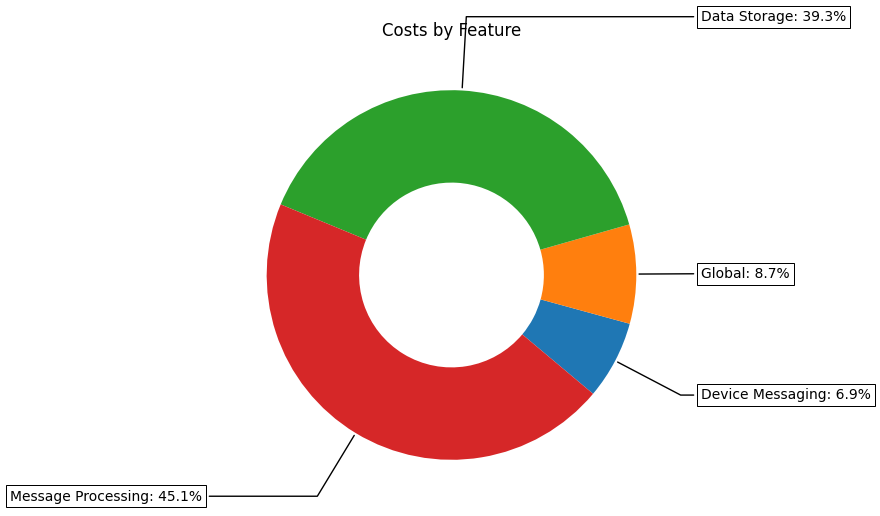

In [10]:
# Feature Breakdown
feature_breakdown = cost_model.group_by("feature").agg(
    pl.col("cost (monthly)").sum().alias("cost (monthly)"),
)
feature_breakdown = group_into_other(
    feature_breakdown,
    "feature",
    "cost (monthly)",
    2.0,
)
feature_breakdown = feature_breakdown.with_columns(
    (pl.col("cost (monthly)") / pl.col("cost (monthly)").sum() * 100.0).alias("percentage"),
)

display(feature_breakdown.sort(by="cost (monthly)", descending=True))

figure = plot_costs(
    "Costs by Feature",
    feature_breakdown["feature"],
    feature_breakdown["percentage"],
)
plt.show()

service,cost (monthly),percentage
str,f64,f64
"""Lambda""",183.000915,45.127842
"""DynamoDB""",159.563736,39.348257
"""IoT Core""",62.952,15.5239


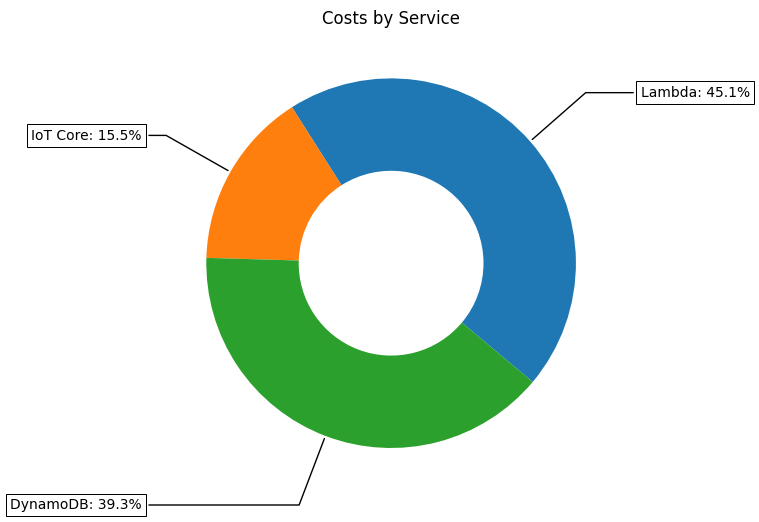

In [11]:
# Service Breakdown
service_breakdown  = cost_model.group_by("service").agg(pl.col("cost (monthly)").sum().alias("cost (monthly)"))
service_breakdown = group_into_other(service_breakdown, "service", "cost (monthly)", 2.0)
service_breakdown = service_breakdown.with_columns(
    (pl.col("cost (monthly)") / pl.col("cost (monthly)").sum() * 100.0).alias("percentage"),
)
display(service_breakdown.sort(by="cost (monthly)", descending=True))

figure = plot_costs(
    "Costs by Service",
    service_breakdown["service"],
    service_breakdown["percentage"],
)
plt.show()

item,cost (monthly),percentage
str,f64,f64
"""Compute Duration""",183.000915,45.127842
"""Write Capacity""",91.5,22.563808
"""Database Storage""",68.063736,16.784449
"""Connection""",35.136,8.664502
"""IoT Rules Engine""",10.98,2.707657
"""Iot Topic Actions""",10.98,2.707657
"""MQTT Messaging""",5.856,1.444084


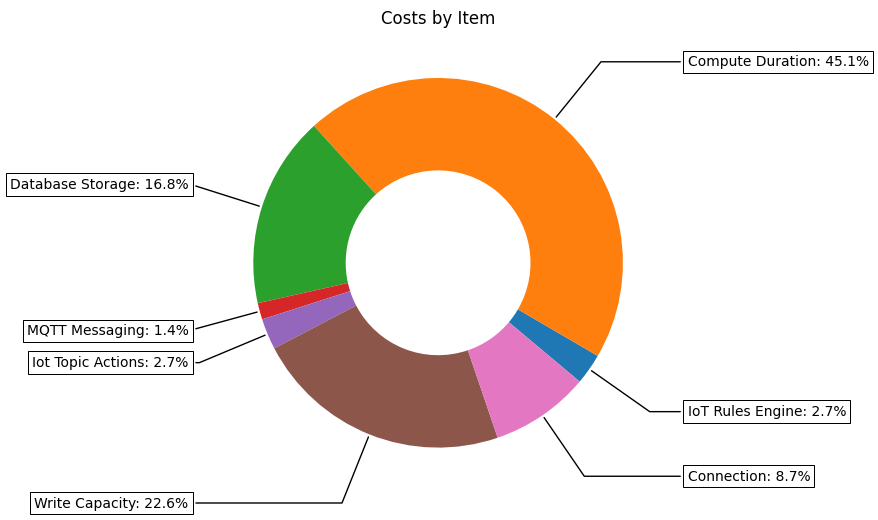

In [12]:
# Item Breakdown
item_breakdown = cost_model.group_by("item").agg(pl.col("cost (monthly)").sum().alias("cost (monthly)"))
item_breakdown = group_into_other(item_breakdown, "item", "cost (monthly)", 2.0)
item_breakdown = item_breakdown.with_columns(
    (pl.col("cost (monthly)") / pl.col("cost (monthly)").sum() * 100.0).alias("percentage"),
)
display(item_breakdown.sort(by="cost (monthly)", descending=True))

figure = plot_costs(
    "Costs by Item",
    item_breakdown["item"],
    item_breakdown["percentage"],
)
plt.show()